In [1]:
def num_eq(eq):
    Eq_list.append(eq)
    eq_num = eq_subs(eq, *Eq_list).subs(params).simplify()
    return eq_num


In [2]:
%run "..\src\utils\notebook_style.ipynb"

# Numerische Integration der Krümmung

## Einführung

Ziel ist die Deformationen des Versuchs A3 in der Versuchsanordnung 2 aus @Jaeger2006 nachzurechnen.

## Momenten-Krümmungsdiagramm

Das Momenten-Krümmungsdiagramm ist geeignet zur Beschreibung des Tragverhaltens von überwiegend auf Biegung beanspruchte Stabtragwerke.
Zur rechnerischen Ermittlung gelten folgende Annahmen, wie in @Spathelf2022 beschrieben:

- Eben- und senkrechtbleiben der Querschnitte
- Die Betonzugfestigkeit $f_{ct}$ wird, für Zustände nach dem Überschreiten von $f_{ct}$, vernachlässigt
- Linear elastisches Verhalten von Stahl und Beton für die Spannungs- und Verformungsberechnung
- Die Bewehrung überträgt Zug- und Druckkräfte ausschliesslich in Stabrichtung

### Anwendung auf Versuchsbeispiel

Folgend wird ein Momentenkrümmungsdiagramm für den Querschnitt aus dem beschriebenen Versuch berechnet. Die vorhandene Querkraftbewehrung ist nicht dargestellt in @fig-qs_a3.


![Querschnitt des Versuchs A3 zur Bestimmung des Momenten-Krümmungdiagramms](../images/QS_Versuch_A3.svg){#fig-qs_a3}


Vereinfacht wird der Querschnitt folgender massen:


![Vereinfachung der Bewehrungsführung](../images/QS_analyse_1.svg){#fig_qs_1}


#### Verwendete Parameter

In [3]:
f_ct, E_c, b, h, W_c, M_r, E_s, f_c= sp.symbols('f_ct, E_c, b, h, W_c, M_r E_s f_c')

A_i, A_c, A_s, s_x, diam_s = sp.symbols('A_i, A_c, A_s, s_x \\oslash_s')

chi_r, I_1 = sp.symbols('chi_r, I^I')

zeta_c, c_nom, I_2 = sp.symbols('zeta_c c_nom I^{II}')

chi_M = sp.Function('chi')(M)

sigma_c_inf_1, F_c1, z_1 = sp.symbols('sigma_c_inf\,1, F_c\,1 z_\,1')

F_A = sp.symbols('F_A')

z_2 = sp.symbols('F_c\,2 z_\,2')

F_z2, F_c2, f_sy, x_2, epsilon_s2, epsilon_c2, sigma_s2, chi_II, sigma_c_inf_2, M_2 = sp.symbols('F_z\,2 F_c\,2 f_sy x_\,2 varepsilon_s\,2 varepsilon_c\,2 sigma_s\,2 \chi^{II} sigma_c_inf\,2 M_2')

EI_II, EI_I = sp.symbols('EI^{II} EI^I')


epsilon_sy, x_3, F_c3, F_s3, chi_y, M_y = sp.symbols('varepsilon_sy x_\,3 F_c\,3, F_s\,3, \chi_y M_y')

x_4, M_R, epsilon_cw, epsilon_su,epsilon_sw, chi_u = sp.symbols('x_4, M_R varepsilon_cw varepsilon_su varepsilon_sw chi_u')
EI_III = sp.symbols('EI^{III}')


w_1 = sp.symbols('w_1')
Eq_list = []


In [4]:
params = {
    f_ct:3.*unit.N / unit.mm**2,
    E_c:37700.*unit.N / unit.mm**2,
    E_s:200000.*unit.N / unit.mm**2,
    b:800.*unit.mm,
    h:200.*unit.mm,
    s_x: 80.*unit.mm,
    diam_s:12.*unit.mm,
    c_nom:20.*unit.mm,
    F_A:215000*unit.N,
    f_sy:500.*unit.N/unit.mm**2,
    f_c: 63.3*unit.N/unit.mm**2,
    epsilon_cw : 2.3/1000,
    epsilon_sw : 111.7/1000,
}


# params = {
#     f_ct:2.42*unit.N / unit.mm**2,
#     E_c:32000.*unit.N / unit.mm**2,
#     E_s:205000.*unit.N / unit.mm**2,
#     b:300.*unit.mm,
#     h:450.*unit.mm,
#     s_x: 300/0.75*unit.mm,
#     diam_s:14.*unit.mm,
#     c_nom:30.*unit.mm,
#     F_A:50000*unit.N,
#     f_sy:435.*unit.N/unit.mm**2,
#     f_c: 16.5*unit.N/unit.mm**2,
#     epsilon_cw : 3/1000,
#     epsilon_sw : 45/1000,
# }
params_plot = param_value(params)
dict_to_table(params)

|   |   |
|---|---|
| $E_{c} = 37700.0 \, \frac{\text{N}}{\text{mm}^{2}}$ | $E_{s} = 200000.0 \, \frac{\text{N}}{\text{mm}^{2}}$ |
| $F_{A} = 215000 \, \text{N}$ | $\oslash_{s} = 12.0 \, \text{mm}$ |
| $b = 800.0 \, \text{mm}$ | $c_{nom} = 20.0 \, \text{mm}$ |
| $f_{c} = 63.3 \, \frac{\text{N}}{\text{mm}^{2}}$ | $f_{ct} = 3.0 \, \frac{\text{N}}{\text{mm}^{2}}$ |
| $f_{sy} = 500.0 \, \frac{\text{N}}{\text{mm}^{2}}$ | $h = 200.0 \, \text{mm}$ |
| $s_{x} = 80.0 \, \text{mm}$ | $\varepsilon_{cw} = 0.0023 \, $ |
| $\varepsilon_{sw} = 0.1117 \, $ | |


#### Schwerpunkt des Querschnitts

Durch die Bestimmung der Wertigkeit $n$ kann der Querschnitt als homogener Betonquerschnitt zur Bestimmung des Schwerpunkts behandelt werden.

In [5]:
eq_n = sp.Eq(n, E_s / E_c)
eq_n_num = num_eq(eq_n)



display(eq_n,eq_n_num.evalf(3))

     Eₛ
n = ───
    E_c

n = 5.3

Die Querschnittsfläche der Bewehrung:

In [6]:
eq_A_s = sp.Eq(A_s, sp.Mul(2*unit.m,sp.pi * diam_s **2 / (4 * s_x), evaluate=False))
eq_A_s_num = unit.convert_to(num_eq(eq_A_s), unit.mm)

display(eq_A_s, eq_A_s_num.evalf(3))

                       2
             π⋅\oslashₛ 
Aₛ = 2⋅meter⋅───────────
                 4⋅sₓ   

                       2
Aₛ = 2.83e+3⋅millimeter 

Die Betonquerschnittsfläche:

In [7]:
eq_A_c = sp.Eq(A_c, b*h)
eq_A_c_num = unit.convert_to(num_eq(eq_A_c), unit.mm)


display(eq_A_c, eq_A_c_num)

A_c = b⋅h

                         2
A_c = 160000.0⋅millimeter 

Die ideelle Querschnittsfläche resultiert zu:

In [8]:
eq_Ai = sp.Eq(A_i, A_c + A_s *(n-1))
eq_Ai_num = unit.convert_to(num_eq(eq_Ai), unit.mm)


display(eq_Ai,eq_Ai_num.evalf(6))

Aᵢ = A_c + Aₛ⋅(n - 1)

                        2
Aᵢ = 172172.0⋅millimeter 

In [9]:
eq_zeta_c = sp.Eq(zeta_c, sp.Mul(1/A_i,A_c * h/2 + A_s*(n-1) * (c_nom +1.5*diam_s), evaluate=False))
eq_zeta_c_num = unit.convert_to(num_eq(eq_zeta_c), unit.mm)

display(eq_zeta_c, eq_zeta_c_num.simplify().evalf(3))

      A_c⋅h                                   
      ───── + Aₛ⋅(1.5⋅\oslashₛ + cₙₒₘ)⋅(n - 1)
        2                                     
ζ_c = ────────────────────────────────────────
                         Aᵢ                   

ζ_c = 95.6⋅millimeter

#### Flächenträgheitsmoment

Das Flächenträgheitsmoment wird ebenfalls am ideellen Querschnitt bestimmt. Die Eigenträgheitsmomente der Kreisquerschnitte der Bewehrung sind nicht berücksichtigt, lediglich der Steiner-Anteil fliesst in die Berechnung ein:

In [10]:
eq_I_1 = sp.Eq(I_1, b * h**3/12 +b*h*(h/2 - zeta_c)**2 + A_s * (n-1) * (c_nom + sp.Rational(1.5)*diam_s - zeta_c)**2)
eq_I_1_num = unit.convert_to(num_eq(eq_I_1), unit.mm)
display(eq_I_1, eq_I_1_num.evalf(3))


                                           2      3                2
                  ⎛3⋅\oslashₛ             ⎞    b⋅h        ⎛h      ⎞ 
I__I = Aₛ⋅(n - 1)⋅⎜────────── + cₙₒₘ - ζ_c⎟  + ──── + b⋅h⋅⎜─ - ζ_c⎟ 
                  ⎝    2                  ⎠     12        ⎝2      ⎠ 

                         4
I__I = 5.77e+8⋅millimeter 

#### Ungerissen - Zustand 1

Der Querschnitt verbleibt elastisch. Folglich kann das Flächenträgheitsmoment mit $E_c$ multipliziert werden und es resultiert die ungerissene Biegesteifigkeit:

In [11]:

eq_EI_1 = sp.Eq(EI_I, I_1 * E_c)
eq_EI_I_num = num_eq(eq_EI_1)



display(eq_EI_1, eq_EI_I_num.evalf(3))

EI__I = E_c⋅I__I

                     2       
EI__I = 2.17e+7⋅meter ⋅newton


##### Rissmoment

Durch die Ermittlung des Rissmoments kann die Krümmung vor dem Reissen des Betons ermittelt werden. Die Betonzugkraft wird nicht berücksichtigt.

![Querschnittsanalyse vor dem Reissen des Betons](../images/QS_analyse_2.svg){#fig-qs2}


Die Druckspannung bestimmt sich zu:

In [12]:
eq_sigma_c_inf1 = sp.Eq(sigma_c_inf_1,f_ct / zeta_c * (h-zeta_c))
eq_sigma_c_inf1_num = unit.convert_to(num_eq(eq_sigma_c_inf1),unit.mm)


display(eq_sigma_c_inf1, eq_sigma_c_inf1_num.evalf(3))


            f_ct⋅(h - ζ_c)
σ_c_inf,1 = ──────────────
                 ζ_c      

            3.27⋅newton
σ_c_inf,1 = ───────────
                      2
            millimeter 

Der Hebelarm der inneren Kräfte:

In [13]:
eq_z_r = sp.Eq(z_1, h - ((h-zeta_c)/3 + c_nom + 3/2 * diam_s))
eq_z_r_num = unit.convert_to(num_eq(eq_z_r), unit.mm)

display(eq_z_r, eq_z_r_num.evalf(3))

                              2⋅h   ζ_c
z_,1 = -1.5⋅\oslashₛ - cₙₒₘ + ─── + ───
                               3     3 

z_,1 = 127.0⋅millimeter

Die Betondruckkraft:

In [14]:
eq_F_c_r = sp.Eq(F_c1,  sigma_c_inf_1 * b * (h-zeta_c)/2)
eq_F_c_r_num = num_eq(eq_F_c_r)

display(eq_F_c_r, eq_F_c_r_num.evalf(3))


        b⋅σ_c_inf,1⋅(h - ζ_c)
F_c,1 = ─────────────────────
                  2          

F_c,1 = 1.37e+5⋅newton

Und schliesslich das Rissmoment:

In [15]:
eq_M_r = sp.Eq(M_r, F_c1 * z_1)
eq_M_r_num = num_eq(eq_M_r)


display(eq_M_r, eq_M_r_num.evalf(3))

Mᵣ = F_c,1⋅z_,1

Mᵣ = 1.74e+4⋅meter⋅newton

Aus dem Rissmoment folgt die Krümmung beim Reissen:

In [16]:
eq_chi_r = sp.Eq(chi_r, M_r / (EI_I))
eq_chi_r_num = unit.convert_to(num_eq(eq_chi_r), unit.m)


display(eq_chi_r,eq_chi_r_num.evalf(3))

       Mᵣ 
χᵣ = ─────
     EI__I

     0.0008
χᵣ = ──────
     meter 

#### Gerissen Elastisch - Zustand 2

Der Querschnitt nach dem Reissen ist in @fig-qs3 dargestellt. Der Betonstahl hat die Fliessgrenze noch nicht erreicht. Der Beton die Druckfestigkeit ebenfalls nicht.

![Querschnittsanalyse nach dem Reissen des Betons](../images/QS_analyse_3.svg){#fig-qs3}

Dabei beträgt die statische Höhe:

In [17]:
eq_d = sp.Eq(d,h - c_nom - sp.Rational(1.5) * diam_s)
eq_d_num = num_eq(eq_d)

display(eq_d, eq_d_num)

      3⋅\oslashₛ           
d = - ────────── - cₙₒₘ + h
          2                

d = 162.0⋅millimeter

Nachfolgend werden bekannte Beziehungen dargestellt. Mittels Gleichgewicht der Kräfte lässt sich die Betondruckzonenhöhe und folglich die gerissene Biegesteifigkeit herleiten.

Die Betonstahlzugkraft beträgt:


In [18]:
eq_F_z2 = sp.Eq(F_z2, sigma_s2*A_s)

Eq_list.append(eq_F_z2)

display(eq_F_z2)


F_z,2 = Aₛ⋅σ_s,2

Die Betonstahlspannung für linear elastisches Verhalten:

In [19]:
eq_sigma_s2 = sp.Eq(sigma_s2, epsilon_s2 * E_s)
Eq_list.append(eq_sigma_s2)
eq_sigma_s2

σ_s,2 = Eₛ⋅varepsilon_s,2

Die Betondruckkraft anhand des dreieckigen Verlaufs in @fig-qs3:


In [20]:
eq_F_c2 = sp.Eq(F_c2, sigma_c_inf_2 * b * x_2 /2)
Eq_list.append(eq_F_c2)
eq_F_c2


        b⋅σ_c_inf,2⋅x_,2
F_c,2 = ────────────────
               2        

Die Betonspannung ebenfalls bestimmt durch ein linear elastisches Verhalten:

In [21]:
eq_sigma_c_inf2 = sp.Eq(sigma_c_inf_2, epsilon_c2* E_c)
Eq_list.append(eq_sigma_c_inf2)
eq_sigma_c_inf2

σ_c_inf,2 = E_c⋅varepsilon_c,2

Die Betondehnung anhand des Dehnungsverlaufs in @fig-qs3:

In [22]:
eq_epsilon_c2 = sp.Eq(epsilon_c2, epsilon_s2 /(d-x_2) * x_2)
Eq_list.append(eq_epsilon_c2)
eq_epsilon_c2

                 varepsilon_s,2⋅x_,2
varepsilon_c,2 = ───────────────────
                       d - x_,2     

Abschliessend sind die Kräfte ins Gleichgewicht zu setzen:

In [23]:
eq_ggw_1 = sp.Eq(F_c2, F_z2)
Eq_list.append(eq_ggw_1)
eq_ggw_1

F_c,2 = F_z,2

Einsetzen der bestimmten Gleichungen in die Gleichgewichtsbeziehung:

In [24]:
eq_rho = sp.Eq(rho, A_s/(b*d))
Eq_list.append(eq_rho)
display(eq_n, eq_rho)

     Eₛ
n = ───
    E_c

     Aₛ
ρ = ───
    b⋅d

Dabei wird mit $n$ und $\rho$ substituiert um die Gleichung zu vereinfachen.

In [25]:
eq_ggw_1_subs = eq_subs(eq_F_c2, eq_sigma_c_inf2, eq_ggw_1, eq_epsilon_c2, eq_F_z2).subs(E_c, E_s/n).subs(sigma_s2, epsilon_s2 * E_s).subs(A_s, rho*b*d)
eq_ggw_1_subs

                                                  2
                          Eₛ⋅b⋅varepsilon_s,2⋅x_,2 
Eₛ⋅b⋅d⋅ρ⋅varepsilon_s,2 = ─────────────────────────
                                2⋅n⋅(d - x_,2)     

Dies ist nach $x$ aufzulösen:

In [26]:
eq_x_2 = sp.Eq(x_2,sp.solve(eq_ggw_1_subs, x_2)[0])
eq_x_2_num = unit.convert_to(num_eq(eq_x_2),unit.mm)
Eq_list.append(eq_x_2)
display(eq_x_2, eq_x_2_num.evalf(3))

         ⎛         _______________⎞
x_,2 = d⋅⎝-n⋅ρ + ╲╱ n⋅ρ⋅(n⋅ρ + 2) ⎠

x_,2 = 61.4⋅millimeter

Zur Bestimmung der Krümmung ist die Betonstahldehnung erforderlich. Diese bedingt ein einwirkendes Moment. Dazu wird das bereits bekannte Rissmoment angesetzt.

In [27]:
eq_M_2 = sp.Eq(M_2, F_z2 * (d-x_2/3))
eq_M_2_M_r = sp.Eq(M_2, M_r)
Eq_list.append(eq_M_2)
Eq_list.append(eq_M_2_M_r)

display(eq_M_2,eq_M_2_M_r, eq_subs(eq_M_2,eq_M_2_M_r, eq_F_z2, eq_sigma_s2))

           ⎛    x_,2⎞
M₂ = F_z,2⋅⎜d - ────⎟
           ⎝     3  ⎠

M₂ = Mᵣ

                          ⎛    x_,2⎞
Mᵣ = Aₛ⋅Eₛ⋅varepsilon_s,2⋅⎜d - ────⎟
                          ⎝     3  ⎠

Daraus resultiert die Betonstahldehnung:

In [28]:
eq_epsilon_s2 = sp.Eq(epsilon_s2,sp.solve(eq_subs(eq_M_2, eq_x_2, eq_sigma_s2, eq_F_z2, eq_M_2_M_r), epsilon_s2)[0])

eq_epsilon_s2_num = num_eq(eq_epsilon_s2)
Eq_list.append(eq_epsilon_s2_num)


display(eq_epsilon_s2_num.evalf(3))

varepsilon_s,2 = 0.000217

Die Krümmung kann anhand des Dehnungsverlaufs in @fig-qs3 bestimmt werden:

In [29]:
eq_chi_II = sp.Eq(chi_II, epsilon_s2/(d-x_2))
eq_chi_II_num = unit.convert_to(eq_subs(eq_chi_II, eq_x_2_num, eq_d_num, eq_epsilon_s2_num).simplify(), unit.m)
Eq_list.append(eq_chi_II)

display(eq_chi_II,eq_chi_II_num.evalf(3))


             varepsilon_s,2
\chi__{II} = ──────────────
                d - x_,2   

             0.00216
\chi__{II} = ───────
              meter 

Abschliessend folgt die gerissene Biegesteifigkeit zu:

In [30]:

eq_EI_II = sp.Eq(EI_II, M_2 / chi_II)
eq_EI_II_num = eq_subs(eq_EI_II, *Eq_list).subs(params).simplify()

display(eq_EI_II,eq_EI_II_num.evalf(3))



               M₂    
EI__{II} = ──────────
           \chi__{II}

                        2       
EI__{II} = 8.05e+6⋅meter ⋅newton

#### Fliessen der Bewehrung - Zustand 3

Die Biegesteifigkeit $EI^{II}$ gilt bis die Bewehrung fliesst oder der Beton beginnt zu plastifizieren. 

![Querschnittsanalyse für reine Biegung beim Fliessen der Bewehrung](../images/QS_analyse_4.svg){#fig-qs4}

Dazu gilt es zuerst Gleichgewicht der Kräfte zu formulieren:

In [31]:
eq_ggw_fliessen = sp.Eq(A_s * f_sy, x_3 * b * f_c/2)
eq_ggw_fliessen

          b⋅f_c⋅x_,3
Aₛ⋅f_sy = ──────────
              2     

Aufgelöst nach der Druckzonenhöhe:

In [32]:
eq_x_3 = sp.Eq(x_3,sp.solve(eq_ggw_fliessen, x_3)[0])
Eq_list.append(eq_x_3)

eq_x_3_num = unit.convert_to(num_eq(eq_x_3), unit.mm)

display(eq_x_3, eq_x_3_num.evalf(3))

       2⋅Aₛ⋅f_sy
x_,3 = ─────────
         b⋅f_c  

x_,3 = 55.8⋅millimeter

Daraus lässt sich das Fliessmoment bestimmen, welches den Endpunkt im Momenten-Krümmungsdiagramm für den Zustand 2 definiert:

In [33]:
eq_M_y = sp.Eq(M_y, A_s * f_sy * (d-x_3/3))
eq_M_y_num = num_eq(eq_M_y)
display(eq_M_y, eq_M_y_num.evalf(3))

              ⎛    x_,3⎞
M_y = Aₛ⋅f_sy⋅⎜d - ────⎟
              ⎝     3  ⎠

M_y = 2.03e+5⋅meter⋅newton

Die Fliessdehnung des Betonstahls entspricht:

In [34]:
eq_epsilon_sy = sp.Eq(epsilon_sy, f_sy / E_s)

Eq_list.append(eq_epsilon_sy)

eq_epsilon_sy

                f_sy
varepsilon_sy = ────
                 Eₛ 

Abschliessend die Krümmung für den Endpunkt des Zustands 2:

In [35]:
eq_chi_y = sp.Eq(chi_y, epsilon_sy / (d-x_3))

eq_chi_y_num = num_eq(eq_chi_y)

display(eq_chi_y, eq_chi_y_num.evalf(3))

         varepsilon_sy
\chi_y = ─────────────
            d - x_,3  

         0.0235
\chi_y = ──────
         meter 

#### Maximaler Biegewiderstand - Zustand 4

Abschliessen kann der maximale Biegewiderstand durch die plastifizierung der Betondruckzone bestimmt werden. Eine Verfestigung des Betonstahls wird nicht berücksichtigt. Sowie gilt es zu kontrollieren, ob die Betonstahldehnung unterhalb der Bruchdehnung liegt.

![Querschnittsanalyse für reine Biegung beim Fliessen der Bewehrung und plastifizierter Betondruckzone](../images/QS_analyse_5.svg){#fig-qs5}

Vereinfacht werden die Spannungen in der Druckzone konstant verteilt betrachtet. Dazu wird die Druckzonenhöhe abgemindert um Faktor 0.85.

Das Gleichgewicht der Kräfte führt zu:

In [36]:
eq_ggw_R = sp.Eq(A_s * f_sy, sp.Mul(0.85,x_4 * b * f_c, evaluate=False))

display(eq_ggw_R)

Aₛ⋅f_sy = 0.85⋅b⋅f_c⋅x₄

Die Druckzonenhöhe folgt zu:

In [37]:
eq_x_4 = sp.Eq(x_4, sp.solve(eq_ggw_R, x_4)[0])
eq_x_4_num = unit.convert_to(num_eq(eq_x_4),unit.mm)
display(eq_x_4_num.evalf(3))

x₄ = 32.8⋅millimeter

In [38]:
eq_M_R = sp.Eq(M_R, A_s * f_sy * (d-0.85*x_4/2))
eq_M_R_num = num_eq(eq_M_R)

display(eq_M_R, eq_M_R_num.evalf(3))

M_R = Aₛ⋅f_sy⋅(d - 0.425⋅x₄)

M_R = 2.09e+5⋅meter⋅newton

Die Krümmung lässt sich anhand der Betonstauchung ermitteln:

In [39]:
eq_chi_u = sp.Eq(chi_u, epsilon_cw / x_4)
eq_chi_u_num = num_eq(eq_chi_u)

display(eq_chi_u, eq_chi_u_num.evalf(3))

     varepsilon_cw
χᵤ = ─────────────
           x₄     

      0.07
χᵤ = ─────
     meter

Die Betonstahldehnung darf die Bruchdehnung nicht überschreiten:

In [40]:
eq_epsilon_su = sp.Eq(epsilon_su, epsilon_cw / x_4 * (d-x_4))
eq_epsilon_su_num = num_eq(eq_epsilon_su)

display(eq_epsilon_su, eq_epsilon_su_num.evalf(3))

               varepsilon_cw⋅(d - x₄)
varepsilonₛᵤ = ──────────────────────
                         x₄          

varepsilonₛᵤ = 0.00904

Die Bruchdehnung wird nicht überschritten. Der Querschnitt versagt im Druckbereich:

In [41]:
eq_epsilon_sw = sp.Eq(epsilon_sw,params[epsilon_sw])
eq_epsilon_sw

varepsilon_sw = 0.1117

Die Biegesteifigkeit im Bereich 3 beträgt:

In [42]:
eq_EI_III = sp.Eq(EI_III, (M_R)/(chi_u))
eq_EI_III_num = num_eq(eq_EI_III)
display(eq_EI_III, eq_EI_III_num.evalf(3))

            M_R
EI__{III} = ───
             χᵤ

                         2       
EI__{III} = 2.99e+6⋅meter ⋅newton

Im Bereich drei werden die zwei definierten Punkte $M_y, \chi_y$ sowie $M_R, \chi_u$ verbunden.

In [43]:
eq_1 = sp.Eq(chi_y, r + m*M_y)
eq_2 = sp.Eq(chi_u, r + m*M_R)


eq_solve = sp.solve([eq_1,eq_2],[r,m])

m_solve = eq_solve[m].subs(chi_u, M_R/EI_III).subs(chi_y,M_y / EI_II)
r_solve = eq_solve[r].subs(chi_u, M_R/EI_III).subs(chi_y,M_y / EI_II)

chi_M_linear = sp.Eq(chi_M,r_solve + m_solve * M)
chi_M_linear

         ⎛    M_y         M_R   ⎞   M_R⋅M_y     M_R⋅M_y 
       M⋅⎜- ──────── + ─────────⎟   ──────── - ─────────
         ⎝  EI__{II}   EI__{III}⎠   EI__{II}   EI__{III}
χ(M) = ────────────────────────── + ────────────────────
               M_R - M_y                 M_R - M_y      

#### Momenten-Krümmungsdiagramm

Abschliessend lässt sich daraus die Beziehung zwischen Moment und Krümmung darstellen:

In [44]:
eq_chi_M = sp.Eq(chi_M, sp.Piecewise((0,M<0),(M/ (EI_I), M < eq_M_r.lhs), (M_r/(EI_I) +M/(EI_II), M<M_y), (chi_M_linear.rhs , M<M_R)))

display(eq_chi_M)

       ⎧                        0                           for M < 0 
       ⎪                                                              
       ⎪                        M                                     
       ⎪                      ─────                        for M < Mᵣ 
       ⎪                      EI__I                                   
       ⎪                                                              
       ⎪                   M         Mᵣ                               
χ(M) = ⎨                ──────── + ─────                   for M < M_y
       ⎪                EI__{II}   EI__I                              
       ⎪                                                              
       ⎪  ⎛    M_y         M_R   ⎞   M_R⋅M_y     M_R⋅M_y              
       ⎪M⋅⎜- ──────── + ─────────⎟   ──────── - ─────────             
       ⎪  ⎝  EI__{II}   EI__{III}⎠   EI__{II}   EI__{III}             
       ⎪────────────────────────── + ────────────────────  for M < M_R
      

In [45]:
M_chi_params = [
                eq_EI_I_num.rhs,
                eq_EI_II_num.rhs,
                eq_EI_III_num.rhs,
                eq_M_r_num.rhs,
                eq_M_y_num.rhs,
                eq_M_R_num.rhs
                ]

for param in enumerate(M_chi_params):
    M_chi_params[param[0]] = np.float64(unit.convert_to(param[1],[unit.m, unit.N]).subs([(unit.m,1),(unit.N,1)]).subs(params_plot))


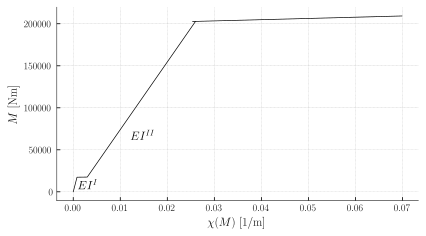

In [46]:
#| label: fig-mchi_diagramm
#| fig-cap: Momenten-Krümmungsdiagramm händisch ermittelt, definiert im positiven Bereich
M_R_num = np.float64(eq_M_R_num.rhs.evalf(4) /unit.m/unit.N)

chi_M_lambda = sp.lambdify((M, EI_I, EI_II, EI_III, M_r, M_y, M_R), eq_chi_M.rhs)

M_array = np.linspace(0,M_R_num * 2, 10000)
chi_M_array = chi_M_lambda(M_array, *M_chi_params)

plt.plot(chi_M_array, M_array, color='black')

# Anmerkungen hinzufügen


plt.annotate('$EI^I$', xy=(0.0009, 15000), xytext=(0, -10), textcoords='offset pixels')
plt.annotate("$EI^{II}$", xy=(0.01, 50000), xytext=(10, 10), textcoords='offset pixels')

plt.xlabel(f'${sp.latex(chi_M)}$ [1/m]')
plt.ylabel(f'${sp.latex(M)}$ [Nm]')
plt.show()


#### Zustandslinien der Biegemomente

Da die Beziehung zwischen Biegemoment und Krümmung bestimmt ist, kann ein Krümmungsverlauf über die Stabachse ermittelt werden. Dieser ist abhängig von der Funktion der Biegemomente zur Stabachse. Die Zustandslinie der Biegemomente wird anhand des statischen Systems in @fig-system_2. 

![Statisches System der Versuchsanordnung](../images/System_anordnung_2.svg){#fig-system_2}

Das Eigengewicht wird vernachlässigt aus folgenden Gründen:

- Die Punktlast $F_A$ ist massgebend am Biegemomentenverlauf beteiligt.
- Die Deformationen im Versuchsbericht aus @Jaeger2006 sind nach dem Einbau des Trägers gemessen worden. Folglich wurde die Deformation des Eigengewichts nicht aufgezeichnet.

$$
g_M, g_{k1}, g_{k2} = 0
$${#eq-eigengewicht}

In [47]:

M_x = sp.Function('M')(x)

F_C = F_A * (1.67-0.11) / (1.67 - 0.75)

eq_M_x = sp.Eq(M_x, sp.Piecewise((0,x<=.110),(F_A * (x-0.11), .750>x), (F_A * 0.64-(F_C-F_A) * (x-0.75), x<=1.670), (0,x>1.670)))
M_x_lambda = sp.lambdify((x, F_A),eq_M_x.rhs)
x_array = np.linspace(0,2.620,5000)
M_x_array = M_x_lambda(x_array, F_A.subs(params_plot))

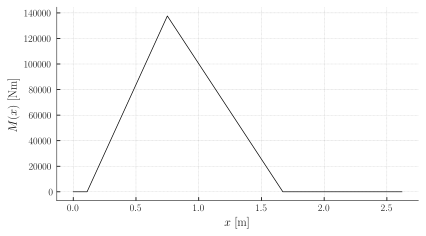

In [48]:
#| label: fig-m_y_diagramm
#| fig-cap: Biegemomentenverlauf für die Laststufe LS14


plt.plot(x_array, M_x_array, color='black')

plt.xlabel(f'${sp.latex(x)}$ [m]')
plt.ylabel(f'${sp.latex(M_x)}$ [Nm]')
plt.show()


#### Zustandslinien der Krümmung

Die Funktion der Biegemomente $M(x)$ als Eingabe in die Funktion der Krümmung $\chi(M)$ resultiert zu folgender Zustandslinie der Krümmung.


In [49]:
chi_M_versuch_2 = chi_M_lambda(M_x_array, *M_chi_params)


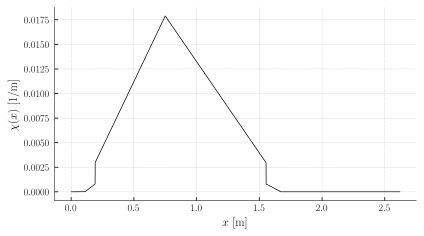

In [50]:
#| label: fig-chi_x_diagramm
#| fig-cap: Krümmungsverlauf für die Laststufe LS14 entlang der Stabachse

plt.plot(x_array, chi_M_versuch_2, color='black')

plt.xlabel(f'${sp.latex(x)}$ [m]')
plt.ylabel(f'$\chi(x)$ [1/m]')
plt.show()


#### Punktuelle Bestimmung der Deformation

Unter Anwendung der Arbeitsgleichung kann die Deformation nach @eq-arbeitsgleichung bestimmt werden.

$$
w = \int_0^l \bar{M}(x) \cdot \frac{M(x)}{EI} d_x
$${#eq-arbeitsgleichung}

Wobei $\frac{M(x)}{EI} = \chi(x)$ gilt.

Das heisst es gilt die Zustandslinien der Krümmung multipliziert mit der Zustandslinie der Biegemomente des virtuellen Kräftezustands über die Stablänge zu integrieren.

In [51]:
M_x_array_bar = M_x_lambda(x_array, 1)

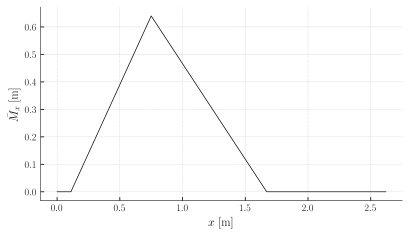

In [52]:
#| label: fig-m_y_diagramm_virtuell
#| fig-cap: Biegemomentenverlauf für den virtuellen Kräftezustand


plt.plot(x_array, M_x_array_bar, color='black')

plt.xlabel(f'${sp.latex(x)}$ [m]')
plt.ylabel('$\\bar{M}_x$ [m]')
plt.show()

In [53]:
def arbeitsgleichung(x):
    return M_x_lambda_bar(x)*chi_M_lambda(M_x_lambda(x), *M_chi_params)

Unter Anwedung der @eq-arbeitsgleichung folgt die Deformation bei der Krafteinleitung $F_A$ zu:

In [54]:
eq_w_p1 = unit.convert_to(sp.Eq(w_1, integrate.quad(lambda x: M_x_lambda(x, 1)*chi_M_lambda(M_x_lambda(x, F_A.subs(params_plot)), *M_chi_params), 0, 2.620)[0]*unit.m), unit.mm)

eq_w_p1.evalf(3)

w₁ = 6.07⋅millimeter